In [ ]:
pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from library1.sb_utils import save_file
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn.decomposition
from pycaret.classification import *
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor,Pool,CatBoostClassifier
import xgboost as xgb
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix

## Load The Data<a id='3.4_Load_The_Data'></a>

In [2]:
ha_data = pd.read_csv('/Users/sharanaravindh/Desktop/springboard/Github repository/capstone 3 - Heart Attack prediction/Data/hearattack_cleaned.csv')

Age: Numeric (e.g., 52)

Sex: Categorical (0: Female, 1: Male)

Chest Pain Type: Categorical (0: Typical Angina, 1: Atypical Angina, 2: Non-anginal Pain, 3: Asymptomatic)

Resting Blood Pressure: Numeric (e.g., 125)

Serum Cholesterol: Numeric in mg/dL (e.g., 212)

Fasting Blood Sugar: Categorical (0: <= 120 mg/dL, 1: > 120 mg/dL)

Resting Electrocardiographic Results: Categorical (0: Normal, 1: Abnormality, 2: Hypertrophy)

Maximum Heart Rate Achieved: Numeric (e.g., 168)

Exercise-Induced Angina: Categorical (0: No, 1: Yes)

Oldpeak (ST Depression): Numeric (e.g., 1.0)

Slope of Peak Exercise ST Segment: Categorical (0: Upsloping, 1: Flat, 2: Downsloping)

Number of Major Vessels Colored by Fluoroscopy: Numeric (0 to 3)

Thalassemia: Categorical (0: Normal, 1: Fixed Defect, 2: Reversible Defect)

In [3]:
columns_to_convert = ['sex','chest_pain','rest_ecg','st_slope','thalassemia','exercise_induced_angina','blood_sugar']
ha_data[columns_to_convert] = ha_data[columns_to_convert].astype('category')

In [4]:
ha_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1007 non-null   int64   
 1   sex                      1007 non-null   category
 2   chest_pain               1007 non-null   category
 3   rest_bp                  1007 non-null   int64   
 4   cholesterol              1007 non-null   int64   
 5   blood_sugar              1007 non-null   category
 6   rest_ecg                 1007 non-null   category
 7   max_heart_rate           1007 non-null   int64   
 8   exercise_induced_angina  1007 non-null   category
 9   st_depression            1007 non-null   float64 
 10  st_slope                 1007 non-null   category
 11  vessels_fluroscopy       1007 non-null   int64   
 12  thalassemia              1007 non-null   category
 13  target                   1007 non-null   float64 
dtypes: categ

In [5]:
ha_data = ha_data.rename(columns={'target':'heart_attack_risk'})

### Preprocessing

#### Encoding

In [6]:
columns_to_encode=['chest_pain','blood_sugar','rest_ecg','exercise_induced_angina','vessels_fluroscopy','thalassemia']
df = pd.get_dummies(ha_data, columns = columns_to_encode) 

#### Scaling

In [7]:
numerical_columns = df.select_dtypes(include=['float','int']).columns

In [8]:
scaler = StandardScaler()
x = scaler.fit_transform(df[numerical_columns]) 
df[numerical_columns]=pd.DataFrame(x, columns = numerical_columns)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.head()

,age,sex,rest_bp,cholesterol,max_heart_rate,st_depression,st_slope,heart_attack_risk,chest_pain_0,chest_pain_1,...,exercise_induced_angina_0,exercise_induced_angina_1,vessels_fluroscopy_0,vessels_fluroscopy_1,vessels_fluroscopy_2,vessels_fluroscopy_3,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
0,-0.287864,1,-0.372147,-0.673204,0.827753,-0.075393,2,-1.060967,1,0,...,1,0,0,0,1,0,0,0,0,1
1,-0.176799,1,0.477888,-0.847645,0.264253,1.707976,0,-0.571343,1,0,...,0,1,1,0,0,0,0,0,0,1
2,1.711300,1,0.761232,-1.409733,-1.036134,1.283364,0,-1.025994,1,0,...,0,1,1,0,0,0,0,0,0,1
3,0.711718,1,0.931239,-0.847645,0.524330,-0.924616,2,-0.886101,1,0,...,1,0,0,1,0,0,0,0,0,1
4,0.822783,0,0.364550,0.916148,-1.859712,0.688908,1,-1.130913,1,0,...,1,0,0,0,0,1,0,0,1,0


In [11]:
X = df.drop('heart_attack_risk',axis=1)
y = df['heart_attack_risk']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### K-nearest Neighbors

In [13]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.347215007320449


In [15]:
print(len(X_test), len(y_test), len(predictions))

191 191 191


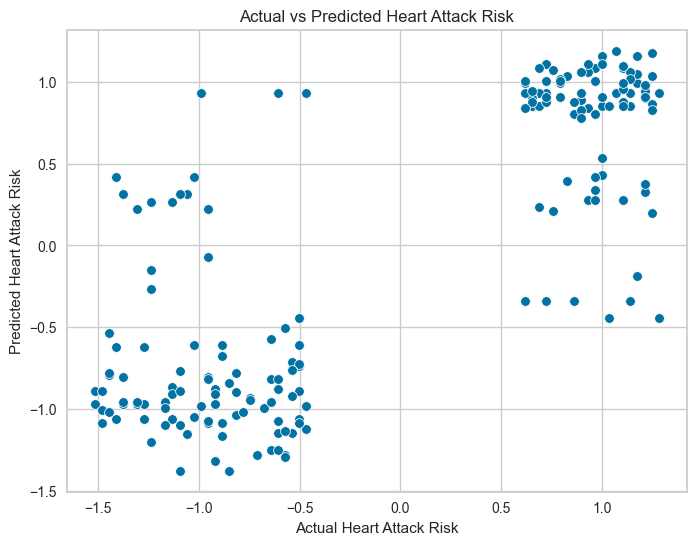

In [16]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Actual vs Predicted Heart Attack Risk')
plt.xlabel('Actual Heart Attack Risk')
plt.ylabel('Predicted Heart Attack Risk')
plt.show()

The Mean Squared Error (MSE) for the KNN Regressor model is calculated to be 0.3472. The MSE is a measure of the average squared difference between the predicted and actual values of the target variable, in this case, the heart attack risk.

The MSE of 0.3472 suggests that, on average, the squared difference between the predicted and actual heart attack risk values is relatively moderate. 

### XG Boost

XGBoost is preferred over KNN Regressor for its superior ability to capture complex relationships and computational efficiency, especially with large datasets. XGBoost gracefully handles missing values, provides feature importance scores, and is less prone to overfitting due to its ensemble nature. The rich set of hyperparameters in XGBoost enables fine-tuning for optimal performance, making it a versatile choice across different scenarios.

In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)

In [18]:
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',             
    'max_depth': 3,                    
    'learning_rate': 0.1,              
    'n_estimators': 100}                

model = xgb.train(params, dtrain, num_boost_round=100)

predictions = model.predict(dtest)

In [19]:
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.303903055837933


#### Hyperparameter Tuning

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)

In [23]:
model = XGBRegressor(enable_categorical=True)  
k = 10
kf = KFold(n_splits=k)
errors = []

for fold, (train_index, test_index) in enumerate(tqdm(kf.split(X, y), total=k)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    error = mean_absolute_error(y_test, y_pred)
    errors.append(error)
    
    print(f"Fold {fold+1} MAE: {error}")

average_error = np.mean(errors)
print("Average MAE:", average_error)

 30%|█████████████▏                              | 3/10 [00:00<00:00, 14.96it/s]

Fold 1 MAE: 0.2699969445143276
Fold 2 MAE: 0.32083217651443857
Fold 3 MAE: 0.261517942795249
Fold 4 MAE: 0.2739631997199913
Fold 5 MAE: 0.3080980818048531


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.55it/s]

Fold 6 MAE: 0.29330322493609357
Fold 7 MAE: 0.28859344189750974
Fold 8 MAE: 0.2649348402838404
Fold 9 MAE: 0.2818341650631874
Fold 10 MAE: 0.273140957513488
Average MAE: 0.2836214975042979


In [24]:
errors

[0.2699969445143276,
 0.32083217651443857,
 0.261517942795249,
 0.2739631997199913,
 0.3080980818048531,
 0.29330322493609357,
 0.28859344189750974,
 0.2649348402838404,
 0.2818341650631874,
 0.273140957513488]

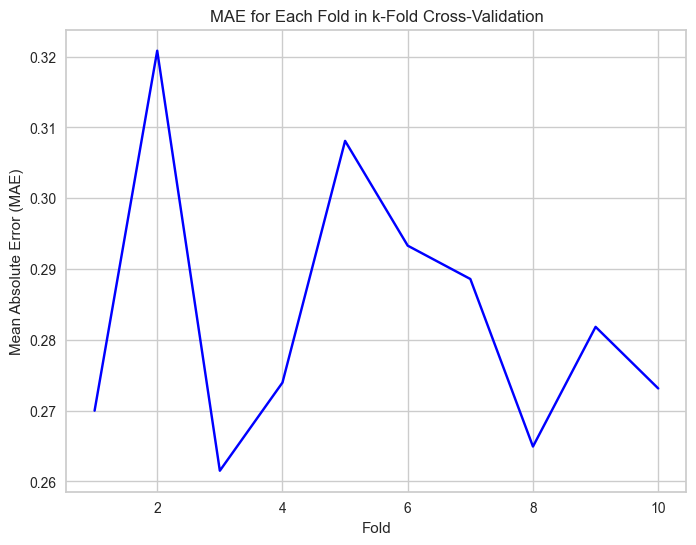

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, k+1), errors, color='blue')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Fold in k-Fold Cross-Validation')
plt.show()

### Random Forest Classifer

In [27]:
threshold = 0.5  
y_binary = (y > threshold).astype(int) 

##### I'm splitting the heart attack risk probability into a binary category by separating the risk below 0.5 as 0 and above 0.5 as 1. This will allow me to run a classifier program. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)


In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
    }
    
rf_model_tuned = RandomForestClassifier(random_state=42)
    
grid_search = GridSearchCV(estimator=rf_model_tuned, param_grid=param_grid, cv=5, scoring='accuracy')
    
grid_search.fit(X, y_binary)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'n_estimators': 50}


In [31]:
final_rf_model = RandomForestClassifier(**best_params, random_state=42)

final_rf_model.fit(X_train, y_train)

y_pred = final_rf_model.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9843
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        98
           1       1.00      0.97      0.98        93

    accuracy                           0.98       191
   macro avg       0.99      0.98      0.98       191
weighted avg       0.98      0.98      0.98       191

Confusion Matrix:
[[98  0]
 [ 3 90]]


Precision: For class 0 (below 0.5 risk), precision is 0.97. This means that 97% of the instances predicted as class 0 were actually below 0.5 risk.

Recall: For class 0, recall is 1.00. This indicates that the model correctly identified all instances where the true risk was below 0.5.

F1-score: The F1-score for class 0 is 0.98, providing a balanced measure of precision and recall.